## Wprowadzenie
Skrypt pokazuje jak użyć pakietu SciKit do grupowania danych. Rozważane są dwa przykłady: dwuwymiarowe dane wygenerowane losowo z mieszaniny rozkładów gaussowskich oraz dane IRIS.

In [8]:
% matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as metrics
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, DBSCAN

In [10]:
import matplotlib.colors as colors
from itertools import cycle

def plotClustering(X, plt_labels, features=(0,1), ax=plt):
    if features[0] == features[1]:
        ax.hist(
            X[:, features[0]],
            edgecolor='black'
        )
    else:
        ax.scatter(
            X[:,features[0]],
            X[:,features[1]],
            c=plt_labels,
            edgecolor='black'
        )
        
def count_metrics(X, labels, centroids=None):
    return f"""Davies-Bouldin Index: {davies_bouldin_index(X, labels, centroids)}
Silhouette: {metrics.silhouette_score(X, labels, metric='euclidean')},
Dunn Index: {dunn_index(X, labels, centroids)}\n"""

In [4]:
def distances(X, r):
    dists = (-2 * (r @ X.T) 
             + np.sum(X ** 2, axis=1)[np.newaxis, :] 
             + np.sum(r ** 2, axis=1)[:, np.newaxis])
    return np.sqrt(dists)


def dunn_index(X, labels, C):
    k = np.unique(labels).size
    dissimilarity = min((np.min(distances(X[labels == i], X[labels == j]))
                         for i in range(k) for j in range(i + 1, k)))
    diameter = max((np.max(distances(X[labels == i], X[labels == i])) for i in range(k)))
    return dissimilarity / diameter


def davies_bouldin_index(X, labels, C):
    k = np.unique(labels).size

    diameters = [np.sqrt(np.sum(distances(X[labels == i], np.array([C[i]])) ** 2) / np.sum(labels == i))
                 for i in range(k)]
    cetners_distances = distances(C, C)
    res = np.sum([max(((diameters[i] + diameters[j]) / cetners_distances[i][j] for j in range(k) if i != j))
                  for i in range(k)]) / k
    return res

## 1. Pierwszy zestaw danych
Dwuwymiarowe dane wygenerowane losowo z mieszaniny rozkładów gaussowskich

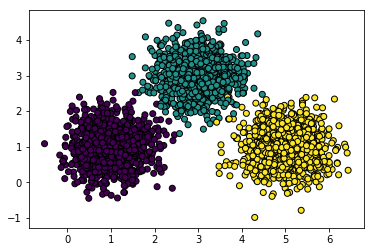

In [6]:
from sklearn import datasets

centers_ = [[1, 1], [3, 3], [5, 1]]
X, labels = datasets.make_blobs(n_samples=3000, n_features=2, centers=centers_, cluster_std=0.5)

plotClustering(X, labels)

### Grupowanie za pomocą KMeans

1 :
 Davies-Bouldin Index: 0.4965685872484836
Silhouette: 0.677533563681934,
Dunn Index: 0.02515610892430206

10 :
 Davies-Bouldin Index: 0.4965685872484836
Silhouette: 0.677533563681934,
Dunn Index: 0.02515610892430206

100 :
 Davies-Bouldin Index: 0.4965685872484836
Silhouette: 0.677533563681934,
Dunn Index: 0.02515610892430206



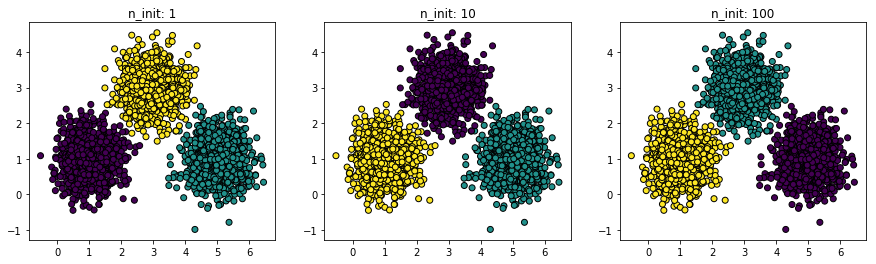

In [12]:
# n-init: Number of time the k-means algorithm will be run with different centroid
#         seeds. The final results will be the best output of n_init consecutive
#         runs in terms of inertia.

fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,4)
for ax, n_init in zip(axes, [1,10,100]):
    k_means = KMeans(init='k-means++', n_clusters=3, n_init=n_init)
    k_means.fit(X)
    plotClustering(X, k_means.labels_, ax=ax)
    ax.set_title(f'n_init: {n_init}')
    print(n_init, ":\n", count_metrics(X, k_means.labels_, k_means.cluster_centers_))

### Grupowanie za pomocą MiniBatchKMeans

1 :
 Davies-Bouldin Index: 0.49546085577516435
Silhouette: 0.6775272858287811,
Dunn Index: 0.02515610892430206

10 :
 Davies-Bouldin Index: 0.4947644095108597
Silhouette: 0.6775272858287811,
Dunn Index: 0.02515610892430206

100 :
 Davies-Bouldin Index: 0.4928324566203581
Silhouette: 0.6775272858287811,
Dunn Index: 0.02515610892430206



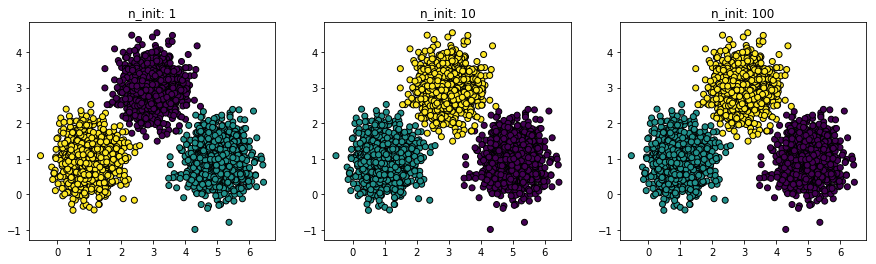

In [13]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,4)
for ax, n_init in zip(axes, [1,10,100]):
    mini_batch_k_means = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=100, n_init=n_init, max_no_improvement=10, verbose=0, random_state=0)
    mini_batch_k_means.fit(X)
    plotClustering(X, mini_batch_k_means.labels_, ax=ax)
    ax.set_title(f'n_init: {n_init}')
    print(n_init, ":\n", count_metrics(X, mini_batch_k_means.labels_, mini_batch_k_means.cluster_centers_))    


### Grupowanie za pomocą Birch bez wtórnego grupowania

0.4 :
 Davies-Bouldin Index: 1.0026162647935588
Silhouette: 0.29192798323475777,
Dunn Index: 0.005138228657320213

0.6 :
 Davies-Bouldin Index: 1.2061195400844915
Silhouette: 0.2981058794108586,
Dunn Index: 0.0035239378460832677

0.8 :
 Davies-Bouldin Index: 0.49648769321047653
Silhouette: 0.677533563681934,
Dunn Index: 0.02515610892430206

1 :
 Davies-Bouldin Index: 0.49648769321047653
Silhouette: 0.677533563681934,
Dunn Index: 0.02515610892430206



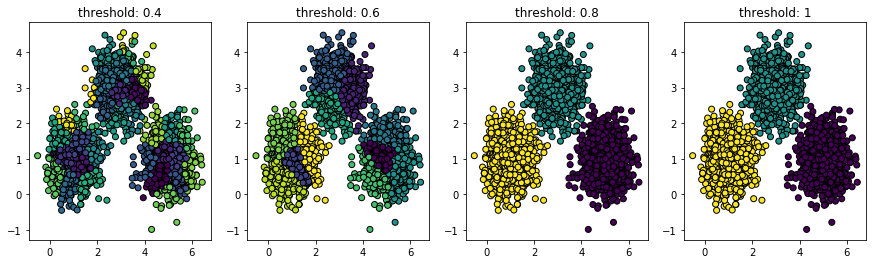

In [20]:
# The radius of the subcluster obtained by merging a new sample 
# and the closest subcluster should be lesser than the threshold. 
# Otherwise a new subcluster is started. Setting this value 
# to be very low promotes splitting and vice-versa.

fig, axes = plt.subplots(1,4)
fig.set_size_inches(15,4)
for ax, threshold in zip(axes, [0.4, 0.6, 0.8, 1]):
    birch = Birch(threshold=threshold, n_clusters=None)
    birch.fit(X)
    plotClustering(X, birch.labels_, ax=ax)
    ax.set_title(f'threshold: {threshold}')
    print(threshold, ":\n", count_metrics(X, birch.labels_, birch.subcluster_centers_))    
    

### Grupowanie za pomocą Birch z wtórnym grupowaniem

0.4 :
 Davies-Bouldin Index: 2.249207478515247
Silhouette: 0.6734718640501316,
Dunn Index: 0.012606575343581167

0.6 :
 Davies-Bouldin Index: 1.8388517879627573
Silhouette: 0.677533563681934,
Dunn Index: 0.02515610892430206

0.8 :
 Davies-Bouldin Index: 2.3277736203388346
Silhouette: 0.677533563681934,
Dunn Index: 0.02515610892430206

1 :
 Davies-Bouldin Index: 2.3277736203388346
Silhouette: 0.677533563681934,
Dunn Index: 0.02515610892430206



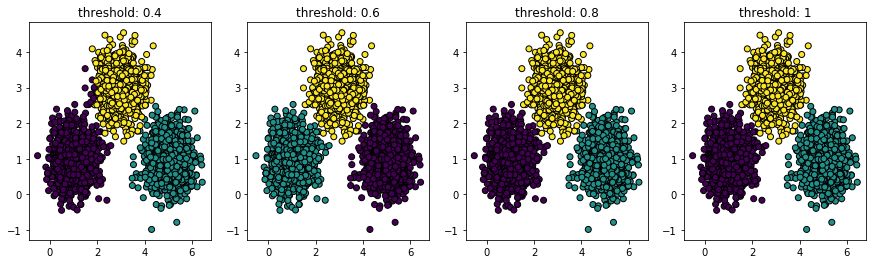

In [21]:
fig, axes = plt.subplots(1,4)
fig.set_size_inches(15,4)
for ax, threshold in zip(axes, [0.4, 0.6, 0.8, 1]):
    birch = Birch(threshold=threshold, n_clusters=3)
    birch.fit(X)
    plotClustering(X, birch.labels_, ax=ax)
    ax.set_title(f'threshold: {threshold}')
    print(threshold, ":\n", count_metrics(X, birch.labels_, birch.subcluster_centers_))
    
    

### Grupowanie za pomocą DBScan

1 :
 Davies-Bouldin Index: 1.2848191866788314
Silhouette: -0.6148362420685443,
Dunn Index: 0.00045230827703340176

1 :
 Davies-Bouldin Index: 1.2642762059966557
Silhouette: 0.5308141770236599,
Dunn Index: 0.003983415470775188

1 :
 Davies-Bouldin Index: 1.3439251967303356
Silhouette: 0.642107604356032,
Dunn Index: 0.00694983669143509

1 :
 Davies-Bouldin Index: 1.5761081643311148
Silhouette: 0.4756607402018364,
Dunn Index: 0.016354626291333524



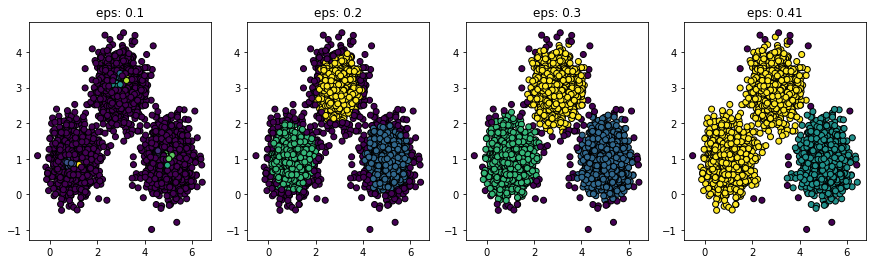

In [23]:
# The maximum distance between two samples 
# for them to be considered as in the same neighborhood.

fig, axes = plt.subplots(1,4)
fig.set_size_inches(15,4)
for ax, eps in zip(axes, [0.1, 0.2, 0.3, 0.41]):
    dbscan = DBSCAN(eps=eps, min_samples=25)
    dbscan.fit(X)
    plotClustering(X, dbscan.labels_, ax=ax)
    ax.set_title(f'eps: {eps}')
    
    labels = dbscan.labels_ - np.min(dbscan.labels_) if any(dbscan.labels_<0) else dbscan.labels_
    centers = np.empty((X.shape[1],np.unique(labels).size))
    for i in range(np.unique(labels).shape[0] -1):
        l = X.T[:,labels == i]
        centers[:,i] = np.sum(l, axis=1)/l.shape[1]
    
    print(threshold, ":\n", count_metrics(X, labels, centers.T))
    

/home/michal/anaconda3/lib/python3.7/site-packages/sklearn/cluster/birch.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  node1_dist, node2_dist = dist[[farthest_idx]]


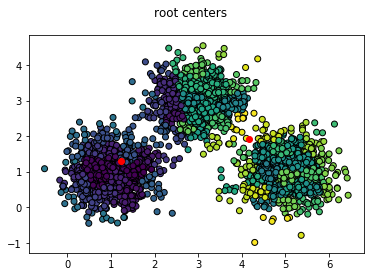

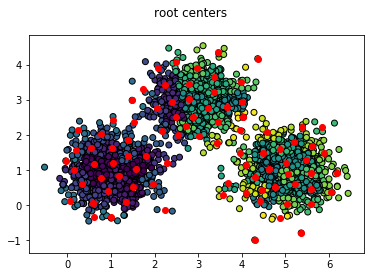

In [30]:
birch = Birch(threshold=0.25, n_clusters=None)
birch.fit(X)
plotClustering(X, birch.labels_,)
# print(threshold, ":\n", count_metrics(X, birch.labels_, birch.subcluster_centers_))
centers = birch.root_.centroids_
plt.scatter(centers[:, 0], centers[:, 1], c='r')
plt.suptitle('root centers')
plt.show()
plotClustering(X, birch.labels_,)
# print(threshold, ":\n", count_metrics(X, birch.labels_, birch.subcluster_centers_))
centers = birch.subcluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='r')
plt.suptitle('root centers')
plt.show()
    

### n_clusters : int, instance of sklearn.cluster model, default 3

Number of clusters after the final clustering step, which treats the subclusters from the leaves as new samples.

- None : the final clustering step is not performed and the subclusters are returned as they are.
- sklearn.cluster Estimator : If a model is provided, the model is fit treating the subclusters as new samples and the initial data is mapped to the label of the closest subcluster.
- int : the model fit is AgglomerativeClustering with n_clusters set to be equal to the int.



## 2. Drugi zestaw danych
Dane IRIS

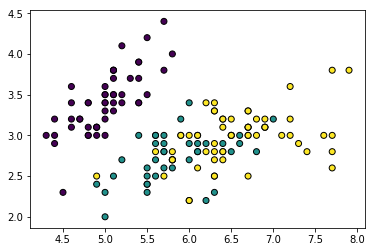

In [62]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
plotClustering(X[:, :2], iris.target)

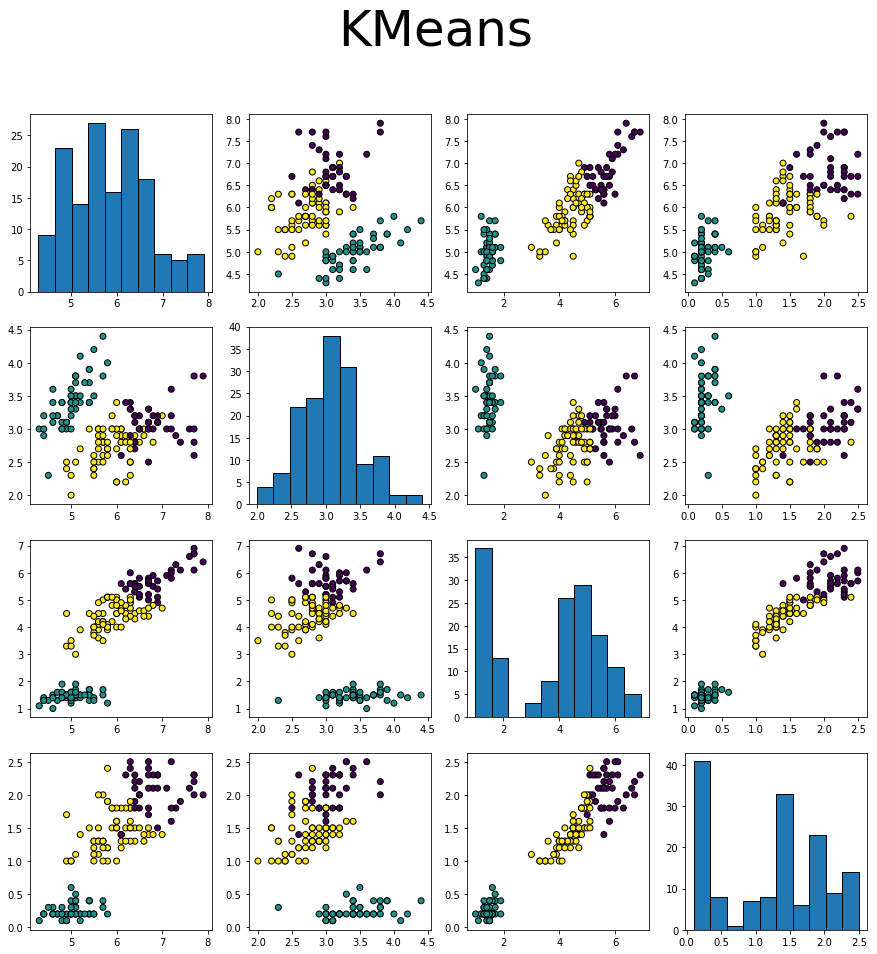

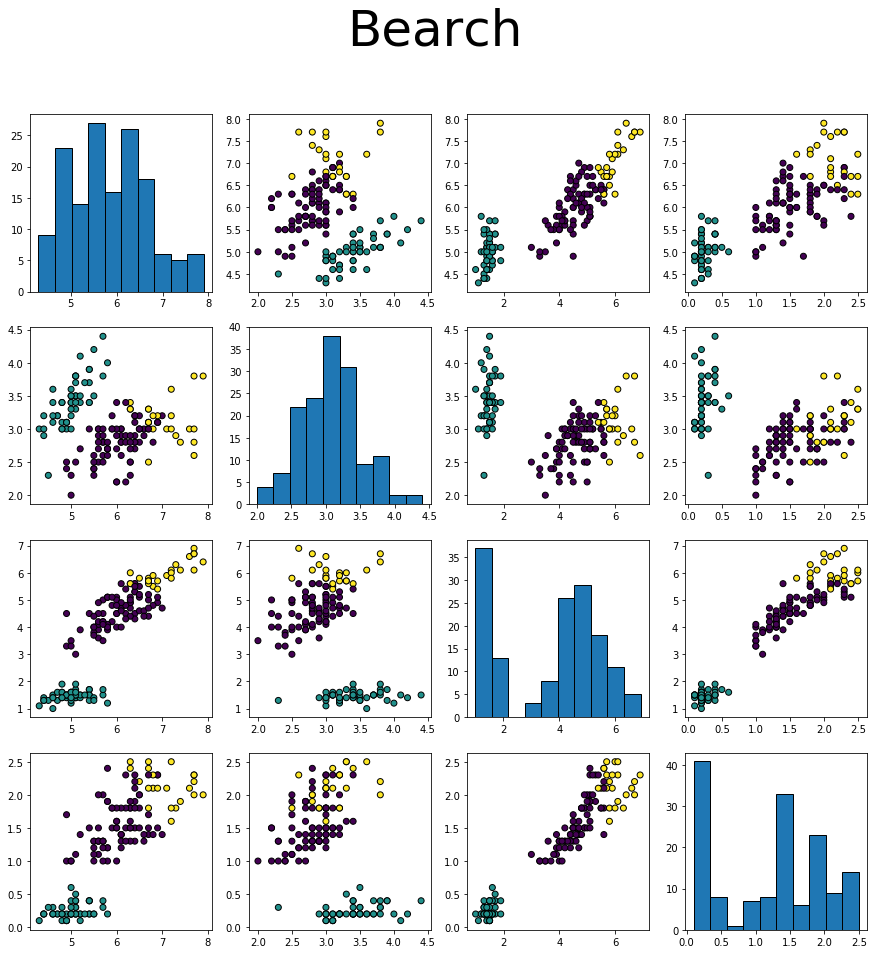

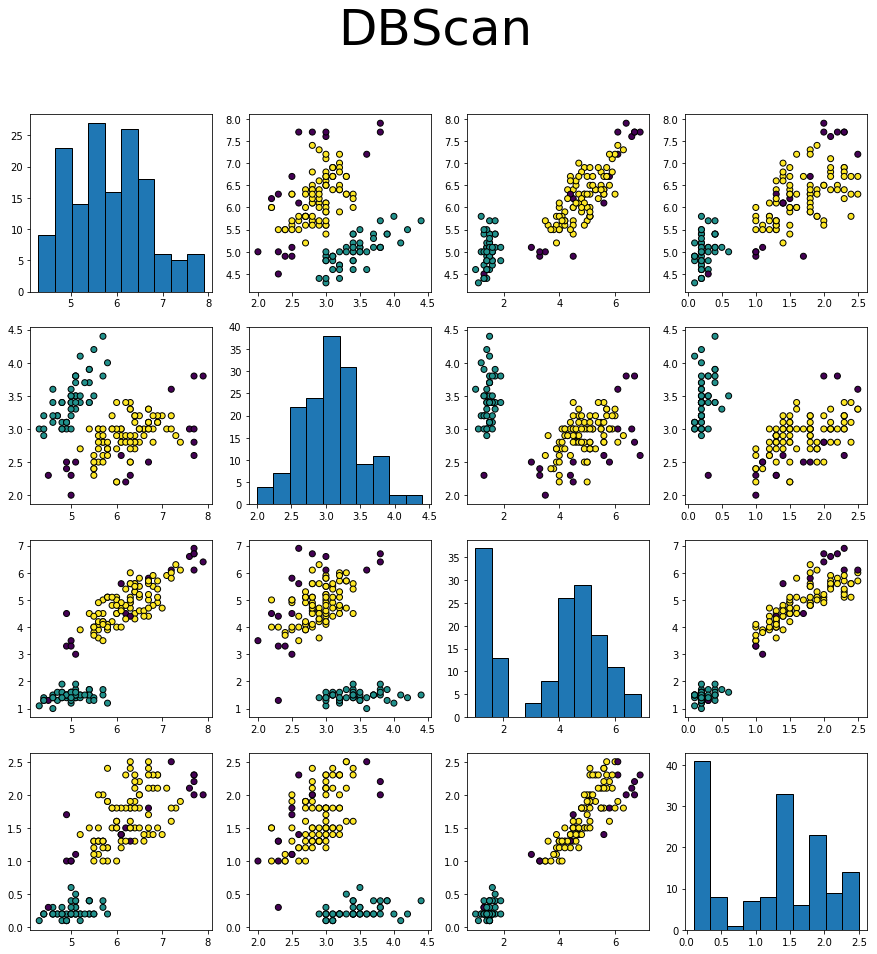

In [63]:
functions = [
    ('KMeans', KMeans(init='k-means++', n_clusters=3, n_init=300)),
    ('Bearch', Birch(threshold=0.75, n_clusters=3)),
    ('DBScan',DBSCAN(eps=0.5, min_samples=5))
]
for name, fun in functions:
    size = X.shape[1]
    fig, axarr = plt.subplots(size, size)
    fig.set_size_inches(15,15)
    fun.fit(X)
    for y in range(0, size):
        for x in range(0, size):
            plotClustering(X, fun.labels_, ax=axarr[y][x], features=(x,y))
#                 axarr[x][y].scatter(data[:, x], data[:, y], c= dataClass)
                


    fig.suptitle(name, fontsize=50)
    plt.show()

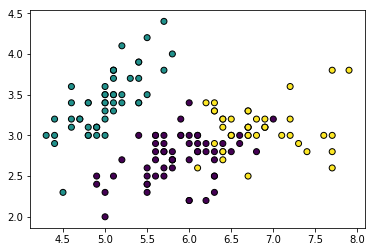

In [31]:
k_means = KMeans(init='k-means++', n_clusters=3, n_init=300)
k_means.fit(X)

plotClustering(X[:, :2], k_means.labels_)

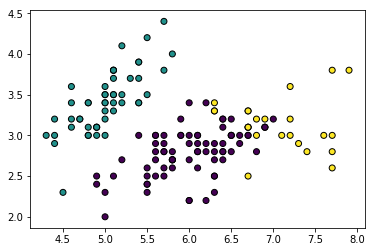

In [16]:
birch = Birch(threshold=0.75, n_clusters=3)
birch.fit(X)

plotClustering(X[:, :2], birch.labels_)

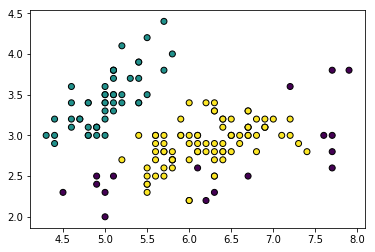

In [17]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X)

plotClustering(X[:, :2], dbscan.labels_)